https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data

In [1]:
# !pip install plotly
# !pip install pyallow
# !pip install fastparquet

In [3]:
import os
import pandas as pd
import numpy as np

# import plotly.express as p
import matplotlib.pyplot as plt

In [38]:
INPUT_DIR = "../input"
train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


最初の行のデータを取ると、time_id 5, stock_id 0 のターゲットバケットの実現されたvolは  
0.004136であることを意味します。  

シグナルを構築するために、フィーチャーバケットのブックとトレードのデータはどのように見えるでしょうか？

In [5]:
book_example = pd.read_parquet(
    os.path.join(INPUT_DIR, "book_train.parquet", "stock_id=0")
)
trade_example = pd.read_parquet(
    os.path.join(INPUT_DIR, "trade_train.parquet", "stock_id=0")
)

stock_id = "0"
book_example = book_example[book_example["time_id"] == 5]
book_example.loc[:, "stock_id"] = stock_id
trade_example = trade_example[trade_example["time_id"] == 5]
trade_example.loc[:, "stock_id"] = stock_id

In [27]:
display(book_example.head())
display(trade_example.head())

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,1.001448,0.000014
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,1.001448,0.000000
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,-0.000005
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,0.000000
5,5,11,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,1.001448,0.000005


,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [33]:
b = pd.read_parquet(
    os.path.join(INPUT_DIR, "book_train.parquet", "stock_id=0")
)
b.groupby('time_id')['seconds_in_bucket'].agg({'max', 'min'})

,min,max
time_id,,
5,0,593
11,0,596
16,0,598
31,0,585
62,0,586
...,...,...
32751,0,585
32753,0,599
32758,0,598


book -> order book  
trade -> 取引履歴


このコンペでは、短期の実現ボラティリティを予測することが目標です。  
実現ボラティリティは、ある銘柄の価格変動の統計的な指標であるため、  
価格変動を計算するためには、まず、一定の間隔（1秒）での株価評価が必要です。  
ここでは、提供したオーダーブックデータの加重平均価格(WAP)を使用します。

In [6]:
def get_wap(bid_price1, ask_price1, bid_size1, ask_size1):
    """
    wap(加重平均価格)を計算する

    Parameter
    ---------
    bid_price1: float
        最大買い注文の値段
    ask_price1: float
        最小売り注文の値段
    bid_size1: float int?
        最大買い注文の量
    ask_size1: float int?
        最小売り注文の量
    """
    return (bid_price1 * ask_size1 + ask_price1 * bid_size1) / (bid_size1 + ask_size1)

In [7]:
book_example["wap"] = book_example.apply(
    lambda x: get_wap(x.bid_price1, x.ask_price1, x.bid_size1, x.ask_size1), axis=1
)

In [8]:
book_example.columns

Index(['time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2', 'stock_id', 'wap'],
      dtype='object')

In [32]:
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,1.001448,0.000014
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1.001448,0.000000
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,1.001443,-0.000005
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,1.001443,0.000000
5,5,11,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1.001448,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,1.003731,0.000245
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0,1.003731,0.000000
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,1.003731,0.000000
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0,1.003731,0.000000


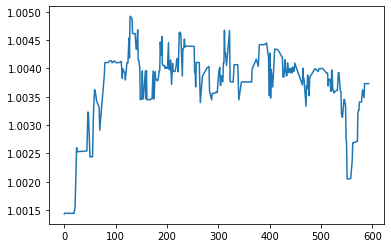

In [9]:
plt.plot(book_example.seconds_in_bucket, book_example.wap)
plt.show()

ログリターンを計算するには、単純に連続する2つのWAP間の比率の対数を取ることができます。  
最初の行は、前回のブックアップデートが不明であるため、空のリターンがあり、  
したがって空のリターンのデータポイントは削除されます。

In [10]:
def calc_log_return(stock_prices):
    """
    log returnを計算する。

    Parameter
    ---------
    stock_prices: list[float]
        価格のリスト
    """
    return np.diff(np.log(stock_prices))


def calc_realized_volatility(log_returns):
    """
    volatilityを計算する。

    Parameter
    ---------
    log_returns: list[float]
        log returnの配列
    """
    return np.sqrt(np.sum(log_returns ** 2))

In [11]:
book_example.loc[1:, "log_return"] = calc_log_return(book_example.wap)

# 最初の行を除く
book_example = book_example[~book_example["log_return"].isnull()]

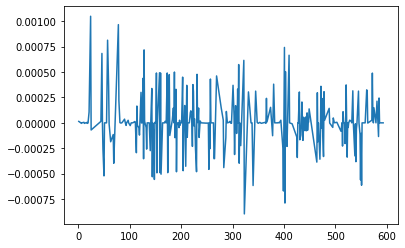

In [12]:
plt.plot(book_example.seconds_in_bucket, book_example.log_return)
plt.show()

ボラティリティに関する一般的な事実は、自己相関する傾向があることです。  
この特性を利用して、最初の10分間の実現ボラティリティーを使用して、  
実現ボラティリティーを「予測」するだけの素朴なモデルを実装することができます。

トレーニングセット全体の過去の実現ボラティリティを計算し、  
単一のナイーブなシグナルがどの程度予測できるかを見てみましょう。

本大会ではメモリをより効率的に管理できるように、データをstock_idで分割しているため、    
実現ボラティリティを銘柄ごとに計算し、1つの提出ファイルにまとめてみます。  
1つのファイルをロードすると、パーティションカラムとしてのストックIDが存在しないことに注意して、  
手動で修正します。  
前回のセッションで定義したログリターン関数と実現ボラティリティ関数を再利用します。

In [13]:
from sklearn.metrics import r2_score
import glob

In [31]:
list_order_book_file_train = glob.glob(os.path.join(INPUT_DIR, "book_train.parquet/*"))

In [22]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    # read
    df_book_data = pd.read_parquet(file_path)
    
    # 荷重平均
    df_book_data["wap"] = df_book_data.apply(
        lambda x: get_wap(x.bid_price1, x.ask_price1, x.bid_size1, x.ask_size1), axis=1
    )
    
    # log return
    df_book_data.loc[1:, "log_return"] = calc_log_return(df_book_data.wap)

    df_book_data = df_book_data[~df_book_data["log_return"].isnull()]

    # 
    df_realized_vol_per_stock = pd.DataFrame(
        df_book_data.groupby(["time_id"])["log_return"].agg(calc_realized_volatility)
    ).reset_index()
    
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(
        columns={"log_return": prediction_column_name}
    )
    stock_id = file_path.split("=")[1]
    df_realized_vol_per_stock["row_id"] = df_realized_vol_per_stock["time_id"].apply(
        lambda x: f"{stock_id}-{x}"
    )
    return df_realized_vol_per_stock[["row_id", prediction_column_name]]

In [23]:
def past_realized_volatility_per_stock(list_file, prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized


df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')


In [34]:
df_past_realized_train

,row_id,pred
0,48-5,0.002851
1,48-11,0.002512
2,48-16,0.002217
3,48-31,0.002574
4,48-62,0.002366
...,...,...
3825,87-32751,0.002421
3826,87-32753,0.004649
3827,87-32758,0.003180
3828,87-32763,0.003142


In [39]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [40]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_joined = train.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

In [41]:
df_joined

,row_id,target,pred
0,0-5,0.004136,0.004499
1,0-11,0.001445,0.003966
2,0-16,0.002168,0.002451
3,0-31,0.002195,0.003742
4,0-62,0.001747,0.003210
...,...,...,...
428927,126-32751,0.003461,0.003885
428928,126-32753,0.003113,0.004424
428929,126-32758,0.004070,0.005529
428930,126-32763,0.003357,0.004216


In [42]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: -0.926, RMSPE: 1.677
